# Semester Project - Continuous time paradigm in Digital Signal Processing investigation

Continuous-Time Digital Signal Processing is a signal processing paradigm that allows the discretization of a signal, working only by means of amplitude quantization. The discrete signal remains continuous in time in the digital domain, allowing a number of advantages from a digital processing point of view, such as removed aliasing phenomena and reduction of quantization error. It has been shown how this method can be achieved with “event-driven” control systems using level-crossing sampling, amplitude quantization and input signal decomposition.

This notebook contains the complete analysis and investigation done on the topic throughout the semester, following these main steps:

1. **Continuous time simulation with oversampling**: a simulation of continuous time signals with an oversampling approach and comparison of the spectral effects of quantization only and quantization+sampling
2. **Theoretical quantization approach**: quantization of a sinusoidal signal realized on a theoretical basis with Fourier series reconstruction
3. **Amplitude sampler**: generalization of the previous step to an arbitrary signal with the construction of an optimized amplitude sampler
4. **Binary wave and FIR reconstruction**: construction of the quantized signal with binary bit waves and performance of multiple FIR for reconstruction




⚠️Before starting⚠️
Make sure you have installed all the following packages and you have all the necessary Python files contained in the repository!

In [1]:
# packages
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

from scipy import signal, fft
from scipy.optimize import brentq


In [2]:
# external function files
import functions, filters_func
import utils
from functions import signals_ex
from functions import amplitude_sampler

In [3]:
%load_ext autoreload
%autoreload 2

## 1. Continuous time simulation with oversampling

In oder to show the effect of combined quantization and sampling on arbitrary signal, one must first try to recreate a signal that is close to continuos time as possible.
The easiest, yet not highly efficient way to do this, is to oversample the signal with an extremely high sampling frequency, resulting in a significantly small signal precision.

Let's try this first with an easy signal, a sinusoidal wave, but different signal examples can be found in the relative notebook.
We start by defining the time vector, given a finite duration and the chosen sampling frequency

In [4]:
# frequency settings
f_wave = 1000 # Hz
fsmp_ct = 120000
fsmp_1 = 44100;

# duration
n_periods = 1000;
duration= n_periods*1/f_wave
xlimit = 2/f_wave

In [5]:
print("Frequency of the sinusoid: ", f_wave, "Hz")
print("Period of the sinusoid: ", 1/f_wave, "s")
print("Over-Sampling frequency: ", fsmp_ct, "Hz")
print("Duration of the sinusoid: ", duration, "s")

Frequency of the sinusoid:  1000 Hz
Period of the sinusoid:  0.001 s
Over-Sampling frequency:  120000 Hz
Duration of the sinusoid:  1.0 s


In [6]:
# continuous time wave
t_ct = functions.time_vector(fsmp_ct, duration) # continuous time vector
s = signals_ex(t_ct, f_wave)                    # define test waveform
x_ct = s.cosine(amp = 0.8)

# sampled wave
t_smp1 = functions.time_vector(fsmp_1, duration) #sampled time vector
s = signals_ex(t_smp1, f_wave)
x_smp1= s.cosine(amp = 0.8)

print("Length of continuous time signal : ", len(t_ct), len(x_ct))
print("Length of sampled signal: ", len(t_smp1), len(x_smp1))

Length of continuous time signal :  120000 120000
Length of sampled signal:  44100 44100


Let's see how the "continuous" time signal and the sampled one look like:

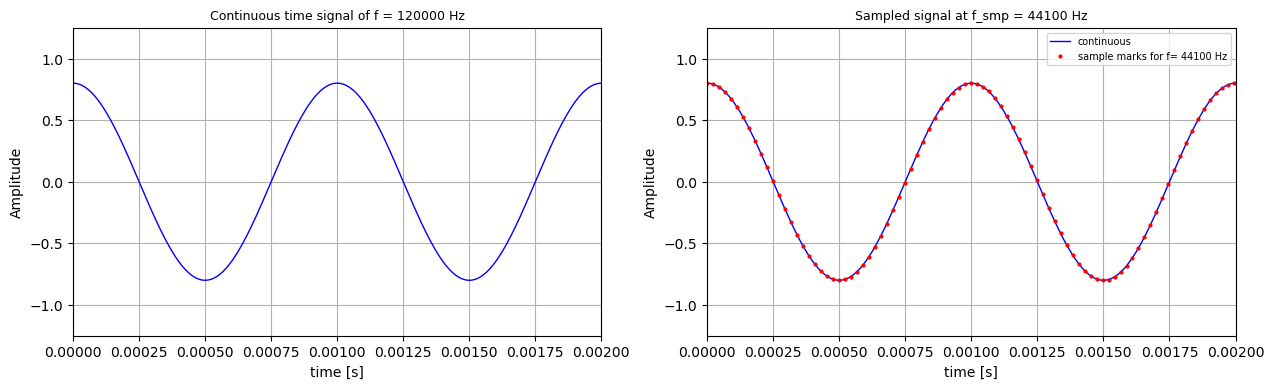

In [7]:
fig = plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='continuous signal', col='b')
plt.title('Continuous time signal of f = %d Hz' %(fsmp_ct),fontsize = 9)
plt.subplot(1,2,2)
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='continuous', col= 'b')
plt.plot(t_smp1, x_smp1,'o',color='red',markersize=2, label= 'sample marks for f= %d Hz' %(fsmp_1))
plt.title('Sampled signal at f_smp = %d Hz' %(fsmp_1),fontsize = 9)
plt.legend(prop={'size': 7})

#### Quantization
Now, we perform quantization on both signals, using a mid-tread quantizer with a total number of steps $N = 2^{N_{bits}} -1$.


In [8]:
q = functions.quantizer(5)    # define quantizer
x_q = q.quantize(x_ct)        # CT signal
x_q_smp1 = q.quantize(x_smp1) # SMP signal

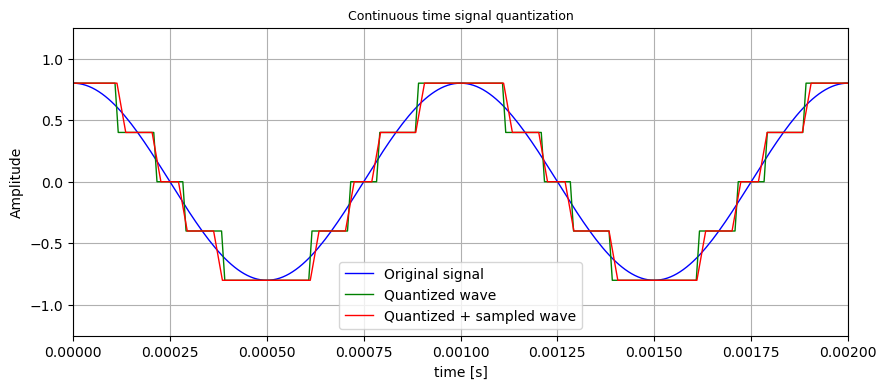

In [9]:
fig = plt.figure(figsize = (10,4))
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='Original signal', col='b')
utils.plot_wave(t_ct, x_q, xlimit, ylim=1.25,label='Quantized wave',col='g' )
utils.plot_wave(t_smp1, x_q_smp1, xlimit, ylim=1.25,label='Quantized + sampled wave',col='r' )
plt.title('Continuous time signal quantization',fontsize = 9)
plt.legend()


In the figure, we can see how the quantized + sampled curve in red has some imperfections, mostly as the transitions point between two levels don't match, causing a slope to the vertical step.

We can further see the flaws of the quantized + sampled wave, comparing the spectral analysis of the three signals in question.

In [10]:
# Fourier analysis
freq_ct, X_ct = utils.fourier_analysis(x_ct, fsmp_ct)
freq_q, X_q = utils.fourier_analysis(x_q, fsmp_ct)
freq_q_smp1, X_q_smp1 = utils.fourier_analysis(q.quantize(x_smp1), fsmp_1)

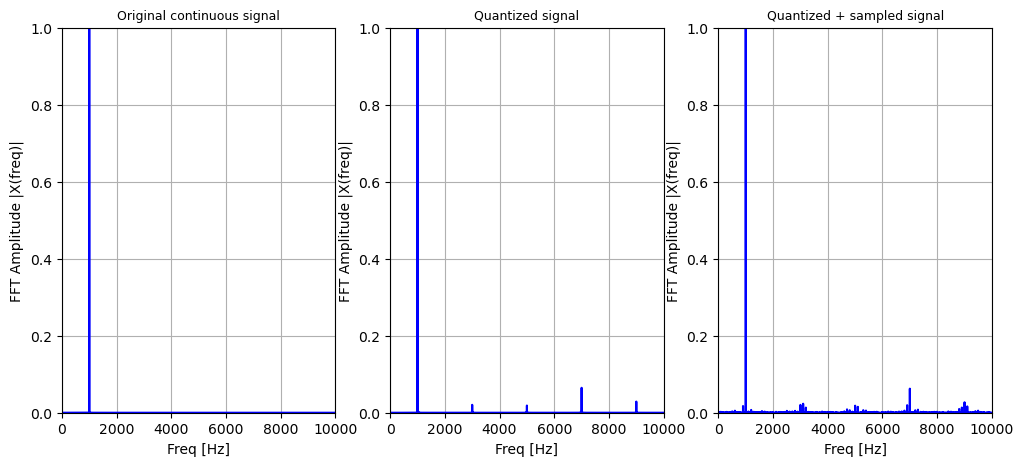

In [11]:
# linear plot
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1)
utils.fourier_plot(freq_ct, X_ct, freq_lim=10000, title="Original continuous signal")
plt.subplot(1,3,2)
utils.fourier_plot(freq_q, X_q, freq_lim=10000, title="Quantized signal")
plt.subplot(1,3,3)
utils.fourier_plot(freq_q_smp1, X_q_smp1, freq_lim=10000, title="Quantized + sampled signal")

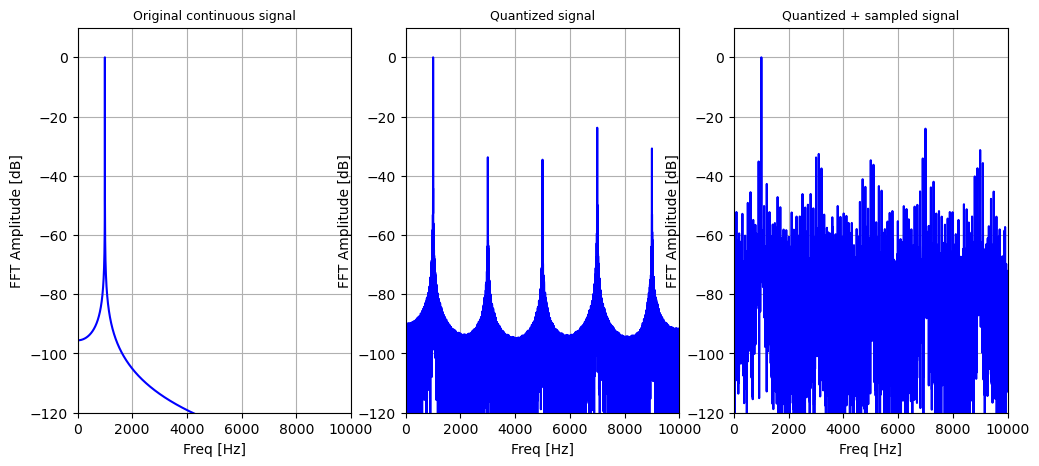

In [12]:
# dB plot
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1)
utils.fourier_plot_db(freq_ct, X_ct, freq_lim=10000, ylim=-120, title="Original continuous signal")
plt.subplot(1,3,2)
utils.fourier_plot_db(freq_q, X_q, freq_lim=10000, ylim= -120, title="Quantized signal")
plt.subplot(1,3,3)
utils.fourier_plot_db(freq_q_smp1, X_q_smp1, freq_lim=10000, ylim=-120,title="Quantized + sampled signal")

It's worth noting the anomalous spectral behaviour showing in both of the processed signlas: multiple odd harmonics are now present in the frequency spectrum, caused by the non-linear characteristic of the quantization.
In the quantized + sampled signal, a significant number of spurious frequencies is also added, causing a very noisy and messy spectra, from which the reconstruction process might heavily suffer in terms of aliasing.

Within this problem lies the interest for a quantization-only method.

## 2. Theoretical Quantization

The oversampling method is helpful to visualize the spectral effects of sampling on a quantized signal, but it is a very computationally heavy task. The higher the frequency of our signal is, the higher the sampling frequency will have to be in order to, first, satisfy the Nyquist criterion, and ,secondly, to achieve a sufficient number of points to mimic the continuous time behaviour, i.e. a smooth and continuous curve.
The reference article presents a theoretical approach to perform a CT quantization to a specific category of deterministic symmetric inputs, of which we will consider the simple case of a symmetric sinusoidal input:

The input signal must have a maximum amplitude that mantains the odd symmetry in the transfer characteristic. In this case, using a 3 bit mid-tread quantizer normalized to $[-1,+1]$, this can be achieved by imposing an upper bound to the amplitude as:
$x_{max} = \left(1 - \frac{1}{2^N} \right)$

For this class of inputs, then, the output of the quantizer can be rewritten as a one-sided Fourier sum:
$$
\large q( t) =  \sum_{n=1}^{\inf} c(n) sin(2\pi \frac{1}{T}\cdot n \cdot t)
$$
where the Fourier coefficients are found to be given by:
$$
\large c(n) = \frac{4\Delta}{\pi n} sin\left(\frac{\pi}{2}n\right)\sum_{n=1}^{N_{steps}} sin ( d_i \cdot \pi \cdot n )
$$

In the previous equation, we have a few more elements that are defined according to a specific formula:
- the **number of steps** $N_{steps}$ above 0 utilized in the first half-cycle: $ N_{ steps} = min \left( 2^{N-1}, int \left( \frac{A + 0.5\Delta}{\Delta}\right) \right) $
- the **duty cicle** $d_i$, related to the duration of time that the input signal spends above the ith positive quantization level boundary when looking at the first half cycle of the input, found as $ d_i = \frac{1}{2} - \frac{1}{\pi} \text{sin}^{-1} \left( \frac{(2i - 1)\Delta}{2A}\right) $

In [13]:
class theory_class:
    # implement the theory parameters of the quantizer with N quantization bits, defined for a sinusoidal input.
    def __init__(self, N):
        self.NBits = N
    def x_max(self):
        # maximum amplitude
        xmax = 1 - 1 / (2 ** self.NBits)
        return xmax
    def step_size(self):
        # size of the quantization steps
        delta_step = (2) / (2 ** (self.NBits))
        return delta_step
    def num_steps(self,amp,delta):
        # number of possible quantizer steps on a half-cycle
        # amp:  amplitude of the signal
        # delta: size of the step
        a = 2 ** (self.NBits- 1) - 1
        b = int((amp + 0.5 * delta) / delta)
        N = np.minimum(a, b)
        return N

In [14]:
def duty(D, amp, n):
    '''
    # D : delta size of the steps
    # amp : amplitude of the signal
    # n : number of steps
    :return: list of the duty cycles of each quantizer level
    '''
    d = np.zeros(n+1)
    for i in range(1,n+1):
        d[i] = 1/2 - (1/np.pi)*np.arcsin((2*i-1)*D/(2*amp))
    return d

def threshold(n, D):
    '''
    # n : number of steps
    # D : delta size of the steps
    :return: height y-value of each quantizer step
    '''
    x = np.zeros(n+1)
    for i in range(1,n+1):
        x[i] = D*((2*i-1)/2)
    return x

In [15]:
#---------signal specifics-------------------
f = 1000
f_smp = f*100
n_periods=1000
dur=n_periods*1/f
T=1/f
T_smp = 1/f_smp
#--------------------------------------------
t= np.linspace(0,dur, int(np.ceil(dur/T_smp)))
sin_wave = np.sin(2*np.pi*f*t)
#--------------------------------------------
print("Duration of the signal is: ", dur, "s")
print("The period of the signal is: ", T, "s")
print("Length of the time vector is: ", len(t), "samples")

Duration of the signal is:  1.0 s
The period of the signal is:  0.001 s
Length of the time vector is:  100000 samples


In [16]:
N_qbits = 3;
th  = theory_class(N_qbits)
delta = th.step_size()
A = th.x_max()
N_steps = th.num_steps(1, delta)
#-----------------------------------------------
print("The max amplitude of the signal is: ", A)
print("The size of the step is: ", delta)
print("The number of steps in a half-cycle is: ", N_steps)

The max amplitude of the signal is:  0.875
The size of the step is:  0.25
The number of steps in a half-cycle is:  3


In [17]:
dc = duty(delta, A, N_steps)[1:]
print("Lenght of duty cicles: {}".format(dc))
x_t = threshold(N_steps, delta)[1:]
print("Height of thresholds: {}".format(x_t))

Lenght of duty cicles: [0.45437105 0.35901704 0.24675171]
Height of thresholds: [0.125 0.375 0.625]


In [18]:
# Fourier coefficients
def c_n(D, nsteps, dc, n_idx):
    '''
    # D : delta size of the steps
    # nsteps : number of steps
    # dc : duty cycle list
    # n_idx : index of the coefficient
    :return: n_th coefficient value
    '''
    cn = 0
    for i in range(1,nsteps+1):
        tmp = (4*D)/(np.pi*n_idx)*np.sin(np.pi*n_idx/2)*np.sin(np.pi*n_idx*dc[i-1])
        cn = cn + tmp
    return cn

# Fourier series
def q_out (D, nsteps, dc, T, t, k):
    '''
    # D : delta size of the steps
    # nsteps : number fo steps
    # dc : duty cycle list
    # T : period of the signal
    # t : time vector
    # k : number of harmonics
    :return: quantized signal as Fourier sum
    '''
    q_out = np.zeros(len(t))
    for i in range(1, k):
        tmp = c_n(D, nsteps, dc, i)*np.sin(2*np.pi*i/T*t)
        q_out = q_out + tmp
    return q_out

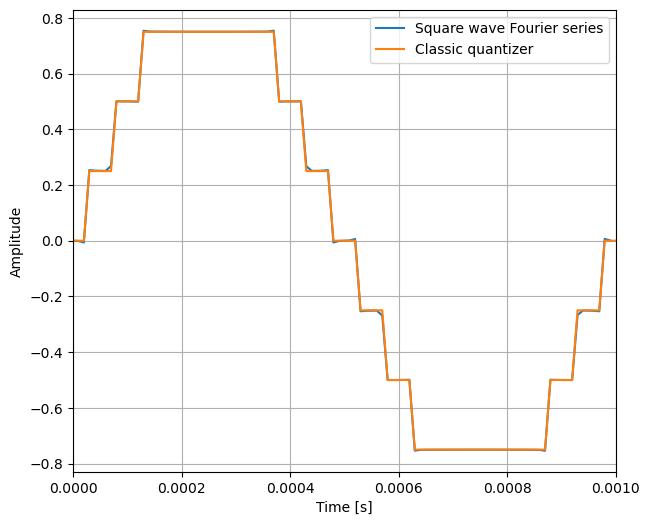

In [19]:
k = 500
c_n(delta, N_steps, dc, 1)
q_th = q_out(delta, N_steps, dc, T, t[0:100], k)
q = functions.quantizer(7)
#--------------------------------------------------------------------
plt.figure(figsize=(7,6))
plt.plot(t[0:100], q_th[0:100], label = 'Square wave Fourier series')
plt.plot(t, q.quantize(sin_wave)*A, label = 'Classic quantizer') #scale quantizer from A = 1 to max amplitude 0.875
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.legend()
plt.xlim(0,T)
plt.grid()
#--------------------------------------------------------------------
q_th = np.tile(q_th, n_periods) # repeat square wave for frequency analysis

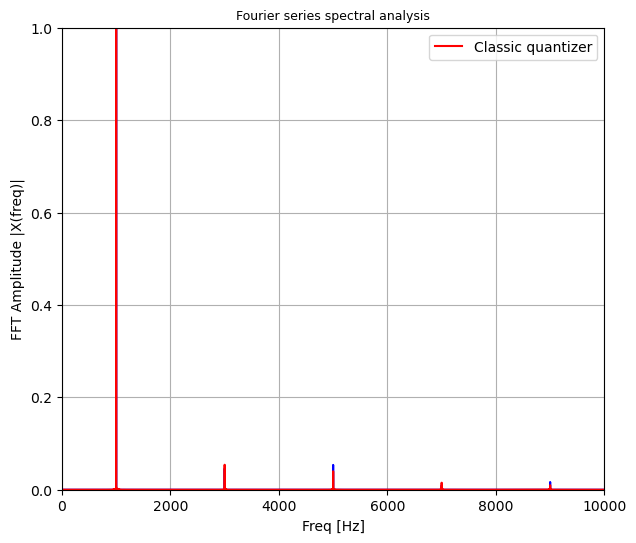

In [20]:
# Fourier frequency analysis
freq_th, X_th = utils.fourier_analysis(q_th, f_smp)
freq_q, X_q = utils.fourier_analysis(q.quantize(sin_wave), f_smp)
#--------------------------------------------------------------------
plt.figure(figsize=(7,6))
utils.fourier_plot(freq_th, X_th, freq_lim = 10000, title= "Fourier series spectral analysis")
plt.plot(freq_q, np.abs(X_q), 'r', label = 'Classic quantizer')
plt.legend()

The reconstructed wave from the theoretical derivation seems to be pretty similar to the one obtain with a classical quantizer, apart from a slightly flawed behaviour in the transitions between levels. The frequency plot is another proof of a good match between the two curves.

## 3. Amplitude sampler
The previous section showed a theoretical approach to construct the quantized signal, limiting it only to the case of sinusoidal inputs. But how can we generalize this method to any kind of signal wave?

In this section, we simulate an algorithm purely based on the principle of amplitude sampling, that does not require the simulation of a wave continuous in time. This is not only helpful for the matter of computational costs, that were ignored when using the oversampling method, but it is also very efficient as it works with a more shallow level of the time precision of the crossing instants.

The amplitude sampler algorithm works following these steps:
- the function takes as input the signal function, its period, the mid-tread quantizer function and a sampling grid to define the sample points per period
- from the quantizer, we get the indices of the quantized function going from 0 (the lowest possible y value) to highest equal to $(2^{N_{bits}}-1)-1$
- iterating over the sample grid, we check for a level transition comparing the bin index of two following grid points
- if a transition has occurred, first determine the threshold value for the amplitude crossing, and then find the exact crossing time between the two neighbouring samples using the <code style="font-family: 'Courier New', monospace;">brentq </code>  optimizer from scipy

Let's see how the amplitude sampler performs:

In [21]:
def test_ampSmp(x):
    f0 = 1.2 # Hz
    return 0.9 * np.sin(2 * np.pi * f0 * x)

In [22]:
#---------------------------------------
T = 1
t_range = np.linspace(0,T,1000)
q = functions.quantizer(5)
#---------------------------------------
t_inst, q_idx = functions.amplitude_sampler(test_ampSmp, T, q) # finds transition instants
bin_step = q.qvalue(q_idx) # find the step value of each bin
#----------------------------------------------------
print('Transition instants: {}'.format(t_inst))
print('Bins index: {}'.format(q_idx))
print('Bins step value: {}'.format(bin_step))

Transition instants: [0.         0.02972127 0.09678314 0.31988353 0.3869454  0.44638794
 0.5134498  0.7365502  0.80361206 0.8630546  0.93011647]
Bins index: [2 3 4 3 2 1 0 1 2 3 4]
Bins step value: [ 0.   0.4  0.8  0.4  0.  -0.4 -0.8 -0.4  0.   0.4  0.8]


The following tests show that the transition points are independent of the initial density of the grid. As long as the grid is not too sparse, we are able to obtain the crossing instants efficiently with fewer points

In [23]:
print(" 10000 points per period grid: {}".format(amplitude_sampler(test_ampSmp, T, q, gd=10000)[0]))
print(" 100 points per period grid: {}".format(amplitude_sampler(test_ampSmp, T, q, gd=100)[0]))

 10000 points per period grid: [0.         0.02972127 0.09678314 0.31988353 0.3869454  0.44638794
 0.5134498  0.7365502  0.80361206 0.8630546  0.93011647]
 100 points per period grid: [0.         0.02972127 0.09678314 0.31988353 0.3869454  0.44638794
 0.5134498  0.7365502  0.80361206 0.8630546  0.93011647]


In [24]:
try:
    amplitude_sampler(test_ampSmp, T, q, gd=10)[0]
except AssertionError:
    print('crossing more than one level')

crossing more than one level


Once the transition instants are found, we can define the multiple "pulses" that construct the quantized signal. Note that these are not step like functions corresponding to the duty-cycle duration of each step, but rather pulses that share the same starting point, and each have a delayed ending, according the relative transition instant

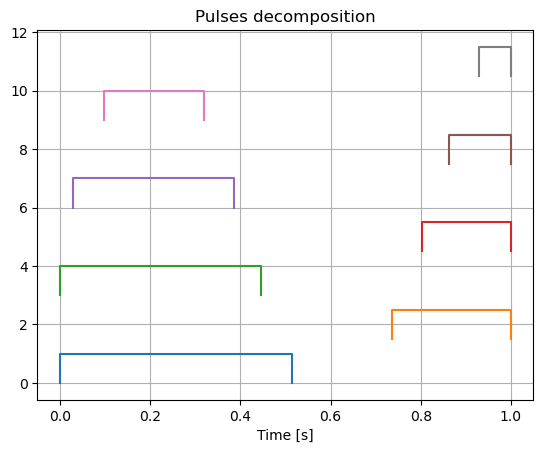

In [25]:
functions.decompose(t_inst, q_idx, T)
n = 0
for p in functions.decompose(t_inst, q_idx, T):
    plt.plot([p[0], p[0], p[1], p[1]], [n, n + 1, n + 1, n])
    n += 1.5
plt.grid()
plt.title("Pulses decomposition")
plt.xlabel("Time [s]")
plt.show()

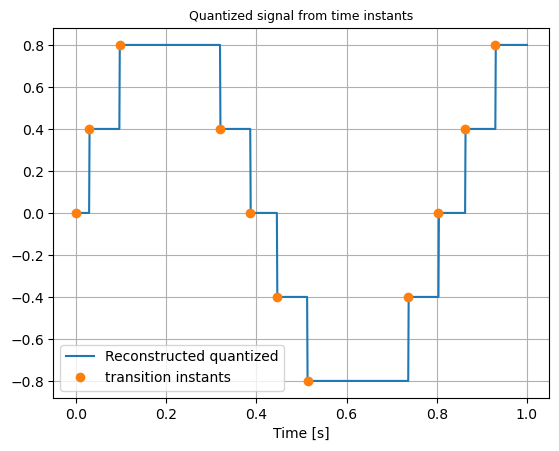

In [26]:
pulse_times = functions.decompose(t_inst, q_idx, T)
functions.plot_decomposition(functions.decompose(t_inst, q_idx, T), q, plot=True)
plt.plot(t_inst, bin_step, 'o', label='transition instants')
plt.title("Quantized signal from time instants", fontsize=9)
plt.xlabel("Time [s]")
plt.legend()
plt.grid()

Following a similar approach to the previous section, starting from the previous decomposition, we can reconstruct the signal using a Fourier series specifically taylord for our pulses functions. Indeed, knowing the crossing instants at the beginning and end of the pulse, namely $t_0$ and $t_1$, and assuming a period of $T$, we find the Fourier series to be as follows:

$$
\Large f ( x ) =  \sum_n c_{n} e^{j 2 \pi \frac{n}{T} x }
$$


with coefficients $C_n$:
$$
\Large c_n = \frac{1}{\pi n} e^{-j 2 \pi n \frac{t}{T} \frac{t_{0} + t_{1}}{2} } \text{sin} ( 2 \pi n \frac{t}{T} \frac{t_{1} - t_{0}}{2} )
$$

In [27]:
# Fourier Series
def FS(n, t0,t1, T, t, delta):
    '''
    # n : number of harmonics
    # t0 : start time instant
    # t1 : end time instant
    # T : signal period
    # x : time vector
    # delta : step size
    :return: one-sided Fourier sum for one step function
    '''
    F=0
    for i in range(1,n):
        c = 1/(np.pi*i) * (np.exp(-1j*2*np.pi*i/T*(t0+t1)/2)*np.sin(2*np.pi*i/T*(t1-t0)/2))
        F_tmp  = delta * c*np.exp(1j*2*np.pi*i*t/T)
        F = F + F_tmp
    return F

C:\Users\Utente\anaconda3\envs\SP_pycharm\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


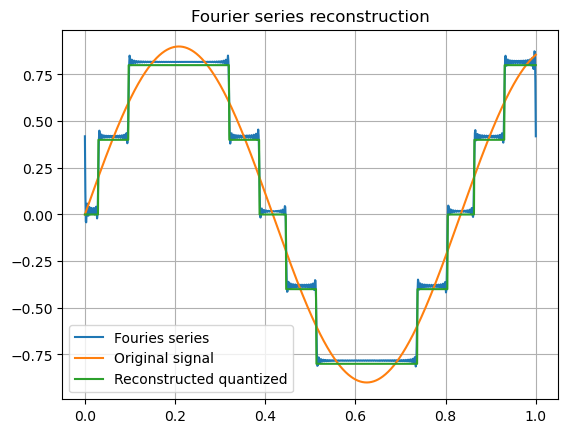

In [28]:
FS_complete = 0
x = np.linspace(0, T, 1000)                   # time vector
pulse_times= functions.decompose(t_inst, q_idx, T) # pulse time intervals
# sum all the step functions together
for i in range(len(pulse_times)):
    F_tmp = FS(200, pulse_times[i][0], pulse_times[i][1],T, x, q.step*2)
    FS_complete = FS_complete + F_tmp
#----------------------------------------------------------------
plt.plot(x, FS_complete + 0.1, label="Fouries series")
plt.plot(x, test_ampSmp(x), label= "Original signal")
functions.plot_decomposition(functions.decompose(t_inst, q_idx, T), q, plot=True)
plt.title("Fourier series reconstruction")
plt.legend()
plt.grid()

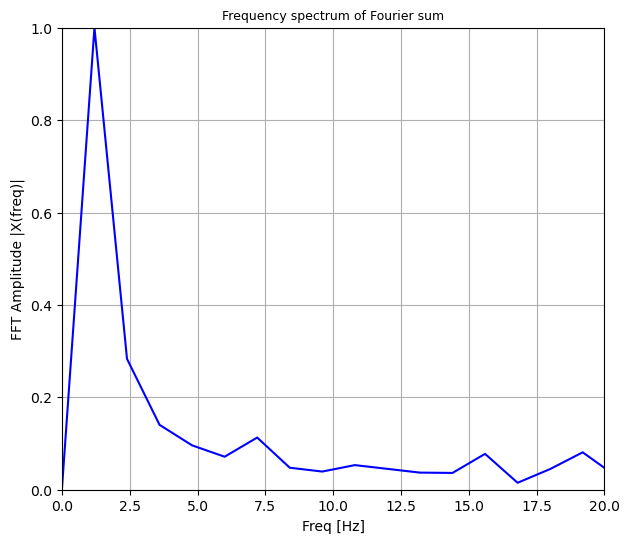

In [29]:
# fourier frequency analysis
freq_FS, X_FS = utils.fourier_analysis(FS_complete, fsmp = 1200)
#---------------------------------------------------------
plt.figure(figsize=(7, 6))
utils.fourier_plot(freq_FS, X_FS, freq_lim=20, title="Frequency spectrum of Fourier sum")

The reconstructed wave with our hand-crafted Fourier series looks promising as well! Since we are dealing with a quantized signal with significant discontinuities, it is not surprising to also observe some Gibbs oscillations at the corners of the wave, but this doesn't seem to affect the frequency spectrum. The results of the Fourier analysis also confirm the behaviour of the amplitude sampler to be very close to that of regular quantizer, that is adding a few odd harmonics to the spectrum.

# 4. Binary wave reconstruction
Since the number of possible levels in our quantizer system is finite, these levels can also be represented by binary words: each level of the quantized wave will be mapped to a binary number according to the number of chosen quantization bits, and the binary waves will represent the trend of a single bit over time, as shown in the figure below.

![Binary words](binary_words.png)

In [30]:
def test(x):
    f0 = 1.2 # Hz
    y = 0.3 * np.sin(2 * np.pi * f0 * x) + 0.5 * np.sin(2 * np.pi * 2 * f0 * x)
    #y = np.cos(2 * np.pi * f0 * x)
    return y

In [31]:
stop_time = 1
N_qbits = 3
q = functions.quantizer(5)
#--------------------------------------
x = np.linspace(0, stop_time, 1000) #time vector
y = test(x) #create waveform

Bins index: [2 3 4 3 2 1 2 3 2 1 0 1 2 3 4 3]
Step value: [ 0.   0.4  0.8  0.4  0.  -0.4  0.   0.4  0.  -0.4 -0.8 -0.4  0.   0.4
  0.8  0.4]


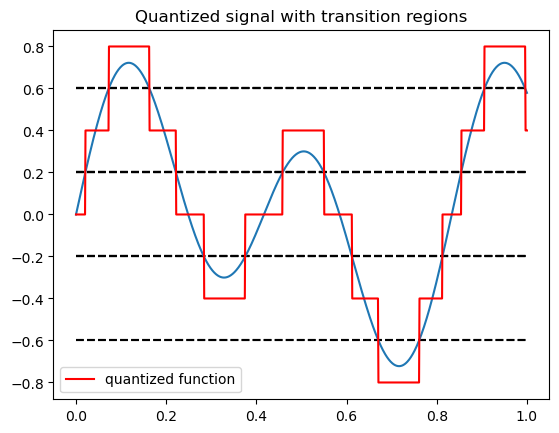

In [32]:
T = int(stop_time)
t, q_idx = amplitude_sampler(test, T, q)
a = q.qvalue(q_idx)  # find the step y value for each bin

print('Bins index: {}'.format(q_idx))
print('Step value: {}'.format(a))
#------------------------------------------------------------------------
for i in range(0,len(q_idx)-1):
    plt.hlines(q.qthreshold(q_idx[i],q_idx[i+1]), 0, 1,'black', linestyles='dashed', label='')
plt.plot(x, test(x))
plt.plot(x, q.quantize(test(x)), 'r', label='quantized function')
plt.title("Quantized signal with transition regions")
plt.legend()

In [33]:
class binary_encoder:
    # Class to encode the index of the quantization bin into a binary string
    def __init__(self, NQbits):
       self.qbits = NQbits
    def binWord(self, bin_index):
        # Convert to binary string, removing the '0b' prefix
        # Fill with zeros to have a fixed length of Nqbits
        binary_list = []
        for i in range(0,len(bin_index)):
            binary_str = bin(bin_index[i])[2:].zfill(self.qbits)
            binary_list.append(binary_str)
        return binary_list

    def bit_extract(self, bi_list, bit_pos):
        # get only the specified position bit
        singlebit = np.array([int(bits[bit_pos]) for bits in bi_list], dtype=int)
        return  singlebit

    def bitmat(self, bi_list):
        # bi_list = list of bin index as binary numbers
        # generates a matrix where each row represents a position bit
        mat = np.zeros(( self.qbits,len(bi_list)))
        for i in range(self.qbits):
            mat[i,:] = self.bit_extract(bi_list, i)
        return mat

    def plot_bitmat(self, mat, x, transitions):
        # prints the matrix of position bits
        mat_plot = np.zeros(( self.qbits,len(x)))
        t_round = np.append(np.round(transitions,3), np.ceil(transitions[-1]))
        for i in range(self.qbits):
            current_row = mat[i,:]
            current_rowplot = mat_plot[i,:]

            for j in range(len(current_row)):
                if current_row[j] == 1:
                    current_rowplot[int(t_round[j]*1000) : int(t_round[j+1]*1000)] = 1

            mat_plot[i,:] = current_rowplot
        return mat_plot

    def plot_bit(self, mat, transitions, x):
        # plots each position bit as a single binary wave
        n_rows = self.qbits
        n_cols = len(x)
        plot_mat= np.zeros((n_rows, n_cols), dtype=int)

        for i in range(self.qbits):
            row = mat[i, :]
            plot_row = plot_mat[i, :]
            t_round = np.round(transitions,3).copy()

            for j in range(len(row)):
                if row[j] == 1:
                    plot_row[int(t_round[j] * n_cols):int(t_round[ + 1] * n_cols)] = 1
            plot_mat[i, :] = plot_row
        return plot_mat


In [34]:
binEnc = binary_encoder(NQbits = 3)
word_list= binEnc.binWord(q_idx)
word_mat = binEnc.bitmat(word_list)
#-------------------------------------
print('Bins index: {}'.format(q_idx))
print('Binary encoding: {}'.format(word_list))
print('Least significant bit: {}'.format(word_mat[2,:]))

Bins index: [2 3 4 3 2 1 2 3 2 1 0 1 2 3 4 3]
Binary encoding: ['010', '011', '100', '011', '010', '001', '010', '011', '010', '001', '000', '001', '010', '011', '100', '011']
Least significant bit: [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


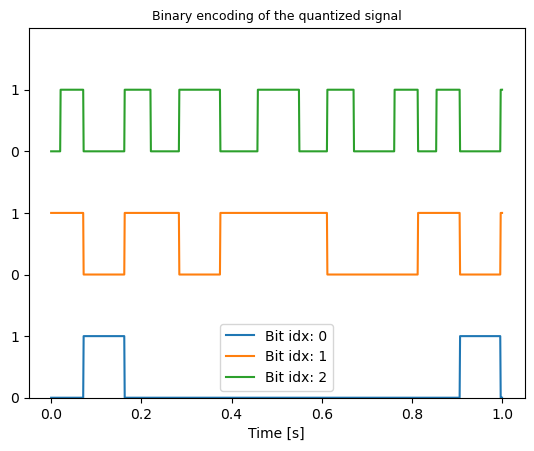

In [35]:
bitEnc = binary_encoder(NQbits = 3)
bit_mat= bitEnc.plot_bitmat(word_mat,x,t)
utils.bitmap_plotter(N_qbits, bit_mat, x)

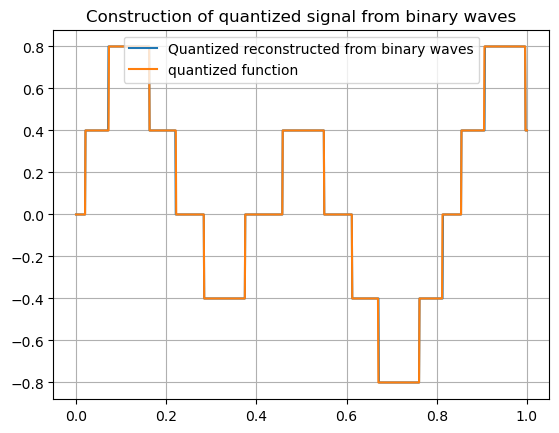

In [36]:
# adding the binary waves together
q_tot = 0
for i in range(1,np.shape(bit_mat)[0]+1):
    #q_temp = 2**(-i+1)*bit_mat[i-1,:]*2*q.step*2
    q_temp = 2**(N_qbits-i)*bit_mat[i-1,:]*q.step
    q_tot = q_tot + q_temp

plt.plot(x, q_tot - q.step*2, label='Quantized reconstructed from binary waves')
plt.plot(x, q.quantize(test(x)), label='quantized function')
plt.title("Construction of quantized signal from binary waves")
plt.grid()
plt.legend()

q_tot =  q_tot - q.step*2

The decomposition into binary words was performed with the help of the amplitude sampler algorithm as well. We can see from the reconstructed signal that also in the scenario, the plot matches exactly that of a regular quantizer.

### FIR definition

In the light of the analog pipeline done by Tsividis, we can implement a further step to complete the digital part of the process from quantization to reconstruction. Indeed, the binary waves found in the previous part can be used to complete a FIR realization.

In this scheme, The $b_n(t)$ waveforms collectively are the digital representation of the input signal $x(t)$ at time $t$. Each one is then processed by N identical CT FIR filters having tap weights $a_k$, with $k \in [0...K]$ and CT delays $T_D$. The N CT FIR filter outputs, $$s_n(t) = \sum_{k=0}^K a_k b_n (t-k\cdot T_D)$$ are then combined by addition, constructing the output $$ y(t) =  \sum_{n=1}^N 2^{-n}\sum_{k=0}^K a_k b_n (t-k\cdot T_D) $$

From the binary wave $b_n$ and the weighted coefficients of 2, we recognize non other than the output of an N-bit CT quantizer $q(t)$, which we were able to obtain in many ways throughtout the entire notebook. Substituting this in the output formula, we find a final form that indeed represents the FIR filter output, determined by tap weights $a_k$ and tap delays $T_D$ of the quantized input: $$y(t) = \sum_{k=0}^K a_k q(t-k\cdot T_D)$$


The final task of this analysis will be to find a good estimation of the currently unknown parameters: the coefficients $a_k$, the time delays $T_D$ and the number of taps K that optimize the performance of our filter.
Let's try to do this by fitting a few commonly used smoothing filter coefficients to our formula, and see how they compare when applied to sampled and quantized version of our signal.


In order to continue the work in a non-sampled regime, the FIR implementations is done by means of the amplitude sampler algorithm.
More explanation on how this is done will be given for each following FIR function.


In [37]:
from filters_func import perform, FIR_class, filters_plot_fourier, filters_plot

In [38]:
def test_FIR(x):
    f0 = 1.2 # Hz
    return 0.9 * np.sin(2 * np.pi * f0 * x)

In [39]:
def find_bin_interval(t_list, t, T, bin_h):
    '''
    # t_list : list of transition instants
    # t : time instant
    # T: duration of the signal
    # bin_h: list of the height of the quantized bins
    :return: the height of the bin for the specific time instant
    '''
    for i in range(1, len(t_list)):
        if t<=t_list[i] and t>=t_list[i-1]:
            return bin_h[i-1]
        if t>=t_list[-1] and t<=T:
            return bin_h[-1]

#### Moving average
The moving average filter is a commonly used FIR that smooths a signal by averaging neighboring samples. The tap weights are all equal to 1/N, with N being the window size of the filter.

In this implementation, the filter takes as input the transitions instants and the corresponding heights of the bins given by the amplitude sampler algorithm, and a  sample time vector. We iterate the latter in two ways: the first according to the filter delay $T_D$, which controls the shift of the window, and the second according to the $\Delta$ time step, amongst the tap of the window.

We are able to find the value of the signal at a specific time instant, by comparison to the reference levels given by the amplitude sampler. For example, if two transition intants $[t_0, t_1]$ correspond to the transitions levels $[1,2]$, we know that at the instant $t_0 + \Delta T < t_1$ will have a value 1.
Using these values, the computation of the average is done simply and most importantly not involving any type of sampling of the quantized signal.

In [40]:
def movingAvg(delta, time, transition_inst, bins_heights,Td, K, W, T):
    '''
    # delta : window delay
    # time : time vector
    # transition_inst : transitions instant
    # bins_heights : height of the bins
    # Td : filter delay
    # K : filter taps
    # W : window taps
    # T : signal duration
    :return: filtered signal
    '''
    filter_out = []
    for k in range(1,K):
        if Td*k > time.max():
            break
        tn = Td*k # current time instant
        level_n = find_bin_interval(transition_inst, tn, T, bins_heights)
        window_sum = level_n
        for w in range(1,W+1):
            tmp = tn-w*delta # shift time instants in the window
            level_tmp = find_bin_interval(transition_inst, tmp, T, bins_heights)
            window_sum += level_tmp
        window_sum = window_sum/W # average sum
        filter_out.append(window_sum)
    return filter_out

In [41]:
t_inst, bins = amplitude_sampler(test_FIR,1, q)
print("Transition instants: {}".format(t_inst))
print("Bin level: {}".format(bins))
print("Bins height: {}".format(q.qvalue(bins)))

Transition instants: [0.         0.02972127 0.09678314 0.31988353 0.3869454  0.44638794
 0.5134498  0.7365502  0.80361206 0.8630546  0.93011647]
Bin level: [2 3 4 3 2 1 0 1 2 3 4]
Bins height: [ 0.   0.4  0.8  0.4  0.  -0.4 -0.8 -0.4  0.   0.4  0.8]


In [42]:
T=1
time_vector= np.linspace(0,T,1000)
bins_h = q.qvalue(bins)
#---------------------------------------------------------------------------------
movAvg_out  = movingAvg(delta = 0.012, time=time_vector, transition_inst = t_inst, bins_heights = bins_h,Td = 0.09, K = 15, W = 7, T=T)

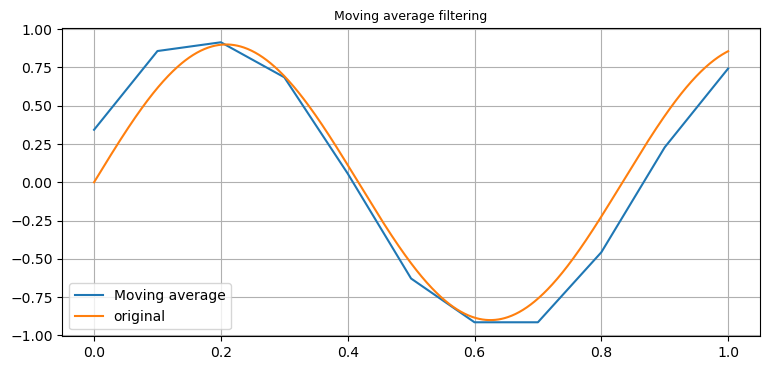

In [43]:
x_fir = np.linspace(0, T, len(movAvg_out))
x = np.linspace(0,T,1000)
#----------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(x_fir, movAvg_out, label='Moving average')
plt.plot(x,test_ampSmp(x), label='original')
plt.title('Moving average filtering', fontsize = 9)
plt.legend()
plt.grid()

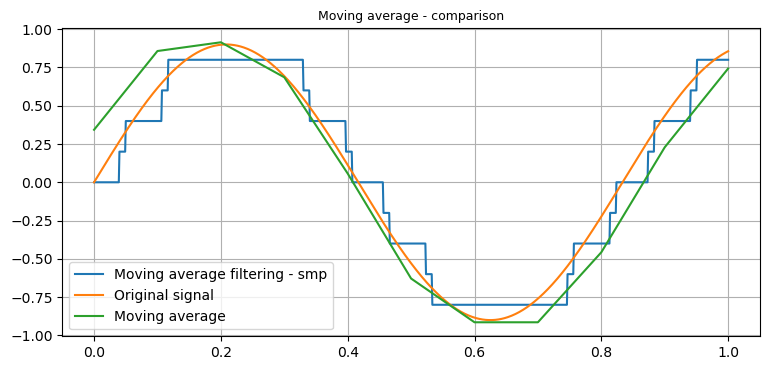

In [51]:
f = FIR_class(taps = 3, delay = 10)
y_fir_smp = f.movingAvg(x,q.quantize(test_FIR(x)))
#--------------------------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(x, y_fir_smp, label='Moving average filtering - smp')
plt.plot(x, test_FIR(x), label='Original signal')
plt.plot(x_fir, movAvg_out, label='Moving average')
plt.title('Moving average - comparison', fontsize=9)
plt.grid()
plt.legend()

#### Hamming window filter
The Hamming window is defined by a mathematical formula that produces a symmetric window with a shape resembling a raised cosine. It is characterized by a main lobe in the frequency domain and a series of smaller sidelobes. The implementation principle is the same as the moving average one, with the difference that its coefficients are found as $$ a_n = 0.54 - 0.46 * cos \left(\frac{(2\pi n)}{(N - 1)} \right) $$

In [45]:
def Hamming(delta, time, transition_inst, bins_heights,Td, K, W, T):
    '''
    # delta : window delay
    # time : time vector
    # transition_inst : transitions instant
    # bins_heights : height of the bins
    # Td : filter delay
    # K : filter taps
    # W : window taps
    # T : signal duration
    :return: filtered signal
    '''

    filter_out = []
    for k in range(1,K):
        if Td*k > time.max():
            break
        tn = Td*k
        level_n = find_bin_interval(transition_inst, tn, T, bins_heights)
        window_sum = level_n
        for w in range(1,W+1):
            a_w= ( 0.54 - 0.46 * np.cos((2*np.pi*w)/(W-1)))
            tmp = tn-w*delta
            level_tmp = find_bin_interval(transition_inst, tmp, T, bins_heights)
            window_sum += level_tmp*a_w
        window_sum = window_sum/W
        filter_out.append(window_sum)
    return filter_out

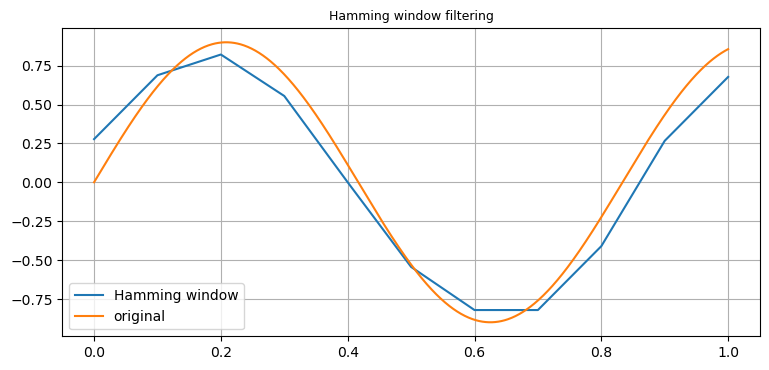

In [46]:
Hamming_out  = Hamming(delta = 0.03, time=time_vector, transition_inst = t_inst, bins_heights = bins_h,Td = 0.09, K = 20, W = 3, T=T)
x_fir = np.linspace(0, T, len(Hamming_out))
x = np.linspace(0,T,1000)
#----------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(x_fir, Hamming_out, label='Hamming window')
plt.plot(x,test_ampSmp(x), label='original')
plt.title('Hamming window filtering', fontsize = 9)
plt.legend()
plt.grid()

0.09746588693957113


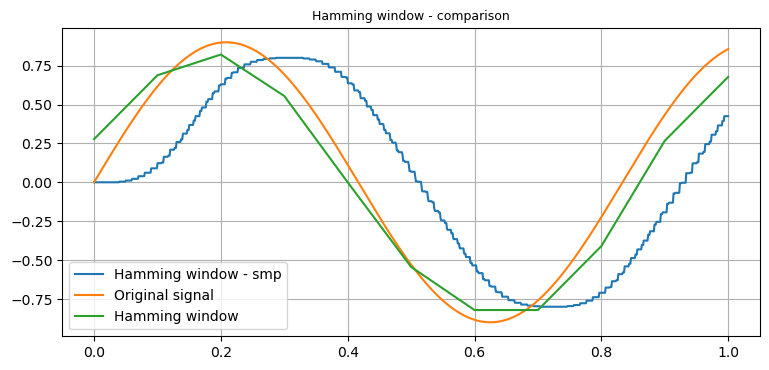

In [47]:
f = FIR_class(taps = 20, delay = 10)
y_fir_smp = f.hamming(x,q.quantize(test_FIR(x)))
#--------------------------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(x, y_fir_smp, label='Hamming window - smp')
plt.plot(x, test_FIR(x), label='Original signal')
plt.plot(x_fir, Hamming_out, label='Hamming window')
plt.title('Hamming window - comparison', fontsize=9)
plt.grid()
plt.legend()

#### Bartlett triangular filter
The Bartlett window, is a type of triangular filter with its maximum value at the center and decreasing linearly towards the edges. It is symmetric and non-zero over a finite length.
The coefficients of a Bartlett triangular window are calculated using the following formula: $$a_n = \frac{2}{(N - 1)}\cdot \frac{(N - 1)}{2} - \left| \frac{n - (N - 1) }{2}\right| $$


In [48]:
def Bartlett(delta, time, transition_inst, bins_heights,Td, K, W, T):
    '''
    # delta : window delay
    # time : time vector
    # transition_inst : transitions instant
    # bins_heights : height of the bins
    # Td : filter delay
    # K : filter taps
    # W : window taps
    # T : signal duration
    :return: filtered signal
    '''
    filter_out = []
    for k in range(1,K):
        if Td*k > time.max():
            break
        tn = Td*k
        level_n = find_bin_interval(transition_inst, tn, T, bins_heights)
        window_sum = level_n
        for w in range(1,W+1):
            a_w= ( (2/W) * ((W-1)/2 - abs((W-1)/2 - w)) )
            tmp = tn-w*delta
            level_tmp = find_bin_interval(transition_inst, tmp, T, bins_heights)
            window_sum += level_tmp*a_w
        window_sum = window_sum
        filter_out.append(window_sum)
    return filter_out

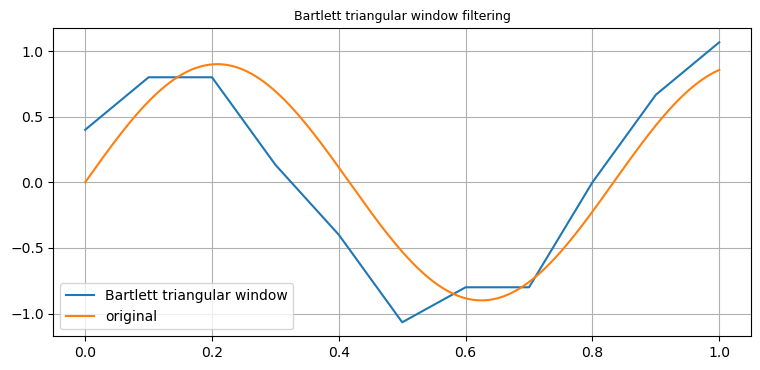

In [49]:
Bartlett_out  = Bartlett(delta = 0.02, time=time_vector, transition_inst = t_inst, bins_heights = bins_h,Td = 0.09, K = 20, W = 3, T=T)
x_fir = np.linspace(0, T, len(movAvg_out))
x = np.linspace(0,T,1000)
#----------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(x_fir, Bartlett_out, label='Bartlett triangular window')
plt.plot(x,test_ampSmp(x), label='original')
plt.title('Bartlett triangular window filtering', fontsize = 9)
plt.legend()
plt.grid()

0.11111111111111108


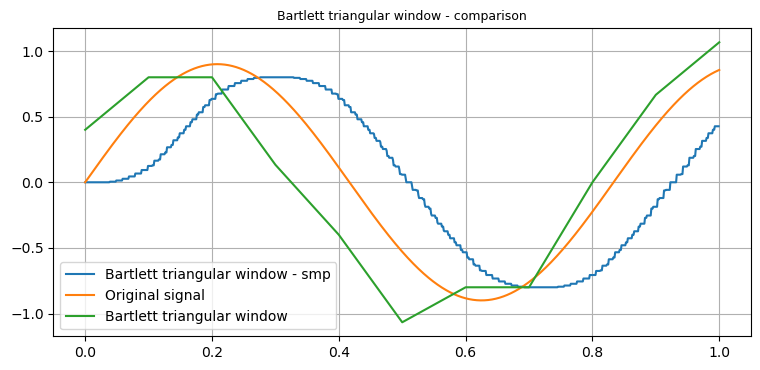

In [50]:
f = FIR_class(taps=20, delay=10)
y_fir_smp = f.bartlett(x, q.quantize(test_FIR(x)))
#--------------------------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(x[:-1], y_fir_smp, label='Bartlett triangular window - smp')
plt.plot(x, test_FIR(x), label='Original signal')
plt.plot(x_fir, Bartlett_out, label='Bartlett triangular window')
plt.title('Bartlett triangular window - comparison', fontsize=9)
plt.grid()
plt.legend()